In [25]:
import os

import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.chdir('/kaggle/input/gas-sensor-array-temperature-modulation')
file_paths = sorted([path for path in os.listdir() if path.endswith('.csv')])

file_paths

['20160930_203718.csv',
 '20161001_231809.csv',
 '20161003_085624.csv',
 '20161004_104124.csv',
 '20161005_140846.csv',
 '20161006_182224.csv',
 '20161007_210049.csv',
 '20161008_234508.csv',
 '20161010_095046.csv',
 '20161011_113032.csv',
 '20161013_143355.csv',
 '20161014_184659.csv',
 '20161016_053656.csv']

### About Data

*https://archive.ics.uci.edu/ml/datasets/Gas+sensor+array+temperature+modulation*

Платформа для обнаружения химических веществ, состоящая из 14 термомодулированных металлооксидных полупроводниковых (МОХ) газовых сенсоров, подвергалась воздействию динамических смесей угарного газа (CO) и влажного синтетического воздуха в газовой камере. 

Представлены временные ряды, полученные с датчиков, и измеренные значения концентрации CO, влажности и температуры внутри газовой камеры. 

- Платформа для обнаружения химических веществ: 
Платформа для обнаружения химических веществ состояла из 14 датчиков МОХ-газа, которые генерируют зависящий от времени многомерный отклик на различные газовые стимулы. 
Используемые датчики были коммерчески доступны от компаний Figaro Engineering (7 единиц TGS 3870-A04) и FIS (7 единиц SB-500-12).
Рабочая температура датчиков контролировалась встроенным нагревателем, напряжение которого модулировалось в диапазоне 0,2-0,9 В циклами по 20 и 25 с в соответствии с рекомендациями производителя (0,9 В в течение 5 с, 0,2 В в течение 20 с, 0,9 В в течение 5 с, 0,2 В в течение 25 с, ...). 
Перед началом экспериментов датчики предварительно нагревались в течение одной недели.
Схемы считывания MOX состояли из делителей напряжения с нагрузочными резисторами 1 МОм и питались напряжением 5 В.
Выходное напряжение датчиков считывалось с частотой 3,5 Гц с помощью Agilent HP34970A/34901A DAQ с точностью 15 бит и входным сопротивлением более 10 ГОм.

- Генератор динамических газовых смесей
Динамические смеси CO и влажного синтетического воздуха подавались из баллонов с газами высокой чистоты в малогабаритную испытательную камеру из политетрафторэтилена (PTFE) (внутренний объем 250 см3) с помощью системы трубопроводов и регуляторов массового расхода (MFC).
Смешивание газов осуществлялось с помощью регуляторов массового расхода (MFC), которые контролировали три различных газовых потока (CO, влажный воздух и сухой воздух). Эти потоки подавались из высококачественных газов под давлением в баллонах.
газа в баллонах. 
Выбранные MFC (EL-FLOW Select, Bronkhorst) имели полномасштабные скорости потока 1000 млн/мин для потоков сухого и влажного воздуха и 3 млн/мин для канала CO. 
Баллон с СО содержал 1600 ppm СО, разбавленного в синтетическом воздухе с 21 Â± 1% O2. 
Относительная погрешность в генерируемой концентрации CO была ниже 5,5%.
Потоки влажного и сухого воздуха подавались из баллона синтетического воздуха с чистотой 99,995% и содержанием O2 21 Â± 1%. 
Увлажнение влажного потока было основано на методе насыщения с использованием стеклянного барботера (бутылки Дрехслера). 

- Значения температуры/влажности
Датчик температуры/влажности (SHT75, от Sensirion) обеспечивал эталонные значения влажности и температуры внутри испытательной камеры с допуском ниже 1,8% об.ч. и 0,5 ºC, соответственно, каждые 5 с.
Колебания температуры внутри газовой камеры для каждого эксперимента составляли менее 3 ºC. 

- Экспериментальный протокол: 
Каждый эксперимент состоял из 100 измерений: 10 экспериментальных концентраций, равномерно распределенных в диапазоне 0-20 ppm, и 10 реплик для каждой концентрации. 
В каждой реплике относительная влажность выбиралась случайным образом из равномерного распределения между 15% и 75% об.ч. 
В начале каждого эксперимента газовая камера очищалась в течение 15 мин с помощью потока синтетического воздуха со скоростью потока 240 млн/мин. 
После этого газовые смеси выпускались в случайном порядке при постоянной скорости потока 240 млн/мин в течение 15 мин каждая. 
Один эксперимент длился 25 часов (100 проб х 15 мин/проба) и был повторен в 13 рабочих дней, охватывающих естественный период в 17 дней.

### About features
Набор данных представлен в 13 текстовых файлах, где каждый файл соответствует отдельному дню измерений. В именах файлов указана временная метка (yyyymmdd_HHMMSS) начала измерений. Каждый файл включает полученные временные ряды, представленные в 20 колонках: Время (с), концентрация CO (ppm), влажность (%r.h.), температура (ÂºC), скорость потока (мл/мин), напряжение нагревателя (В) и сопротивление 14 газовых датчиков: R1 (МОм),R2 (МОм),R3 (МОм),R4 (МОм),R5 (МОм),R6 (МОм),R7 (МОм),R8 (МОм),R9 (МОм),R10 (МОм),R11 (МОм),R12 (МОм),R13 (МОм),R14 (МОм) Значения сопротивления R1-R7 соответствуют датчикам FIGARO TGS 3870 A-04, а R8-R14 соответствуют устройствам FIS SB-500-12. Временные ряды дискретизированы с частотой 3,5 Гц.

In [26]:
data_frames = [pd.read_csv(i, header=0) for i in file_paths]

In [27]:
print(*[data_frame.shape[0] for data_frame in data_frames])

295719 295516 295700 295653 295534 295499 295700 295524 295747 295391 295679 295881 295617


In [28]:
day_1 = data_frames[0]
day_1

,Time (s),CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
0,0.000,0.0,49.7534,23.7184,233.2737,0.8993,0.2231,0.6365,1.1493,0.8483,1.2534,1.4449,1.9906,1.3303,1.4480,1.9148,3.4651,5.2144,6.5806,8.6385
1,0.309,0.0,55.8400,26.6200,241.6323,0.2112,2.1314,5.3552,9.7569,6.3188,9.4472,10.5769,13.6317,21.9829,16.1902,24.2780,31.1014,34.7193,31.7505,41.9167
2,0.618,0.0,55.8400,26.6200,241.3888,0.2070,10.5318,22.5612,37.2635,17.7848,33.0704,36.3160,42.5746,49.7495,31.7533,57.7289,53.6275,56.9212,47.8255,62.9436
3,0.926,0.0,55.8400,26.6200,241.1461,0.2042,29.5749,49.5111,65.6318,26.1447,58.3847,67.5130,68.0064,59.2824,36.7821,66.0832,66.8349,66.9695,50.3730,64.8363
4,1.234,0.0,55.8400,26.6200,240.9121,0.2030,49.5111,67.0368,77.8317,27.9625,71.7732,79.9474,79.8631,62.5385,39.6271,68.1441,62.0947,49.4614,52.8453,66.8445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295714,90908.545,0.0,62.3000,26.5800,0.0000,0.2000,5.5429,2.5713,10.3815,18.5796,36.4589,34.4549,38.3745,57.5888,45.7953,56.6351,56.4058,50.6129,43.0232,65.2822
295715,90908.853,0.0,62.3000,26.5800,0.0000,0.2000,4.5527,2.1454,8.5494,18.0592,36.6290,34.0052,37.6964,51.9752,45.0239,58.9374,61.6173,50.9361,43.4604,63.8761
295716,90909.162,0.0,62.3000,26.5800,0.0000,0.2000,3.7374,1.8492,7.1062,18.0087,36.0127,32.5056,37.1882,54.4724,45.0239,59.7462,57.1452,51.8182,42.5944,64.3090
295717,90909.469,0.0,62.3000,26.5800,0.0000,0.2000,3.1197,1.6190,5.9138,17.6950,37.5930,30.5253,35.9328,51.9752,45.5201,57.7289,60.3791,50.3466,42.4022,62.0375


In [29]:
columns = day_1.columns
columns

Index(['Time (s)', 'CO (ppm)', 'Humidity (%r.h.)', 'Temperature (C)',
       'Flow rate (mL/min)', 'Heater voltage (V)', 'R1 (MOhm)', 'R2 (MOhm)',
       'R3 (MOhm)', 'R4 (MOhm)', 'R5 (MOhm)', 'R6 (MOhm)', 'R7 (MOhm)',
       'R8 (MOhm)', 'R9 (MOhm)', 'R10 (MOhm)', 'R11 (MOhm)', 'R12 (MOhm)',
       'R13 (MOhm)', 'R14 (MOhm)'],
      dtype='object')

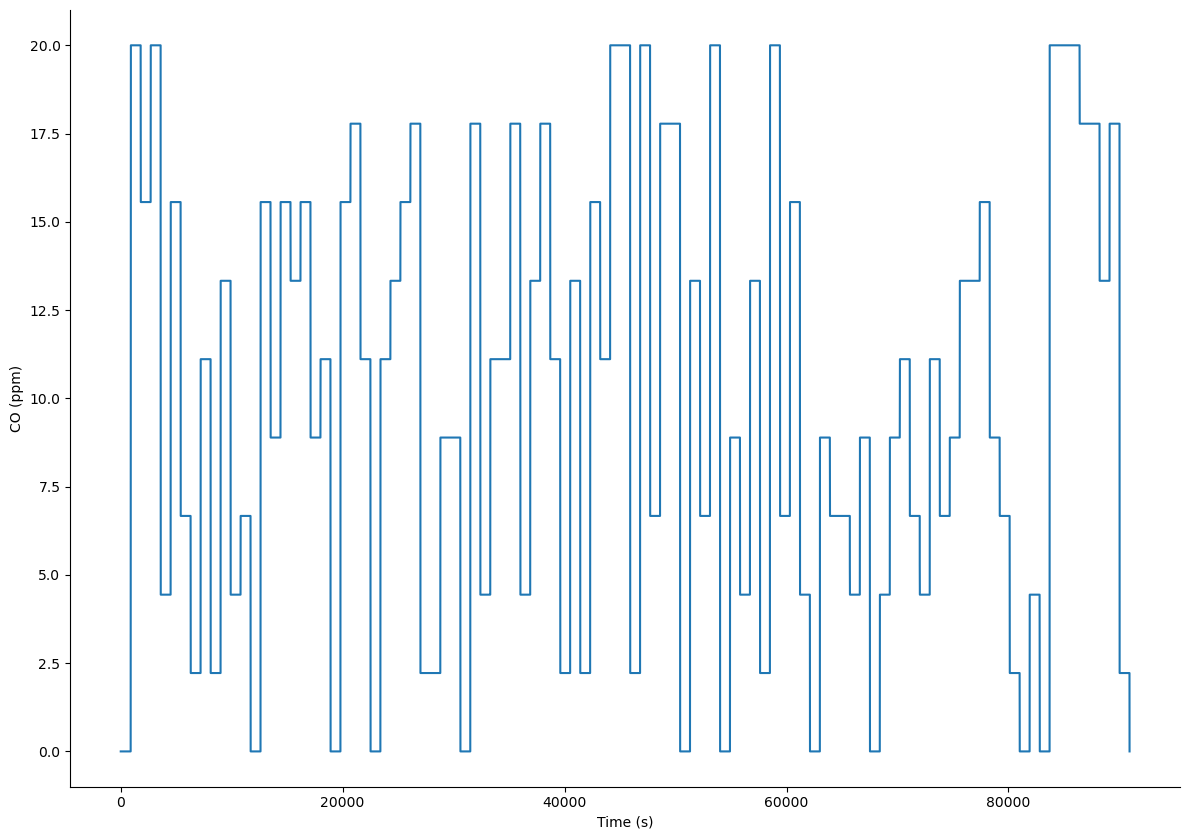

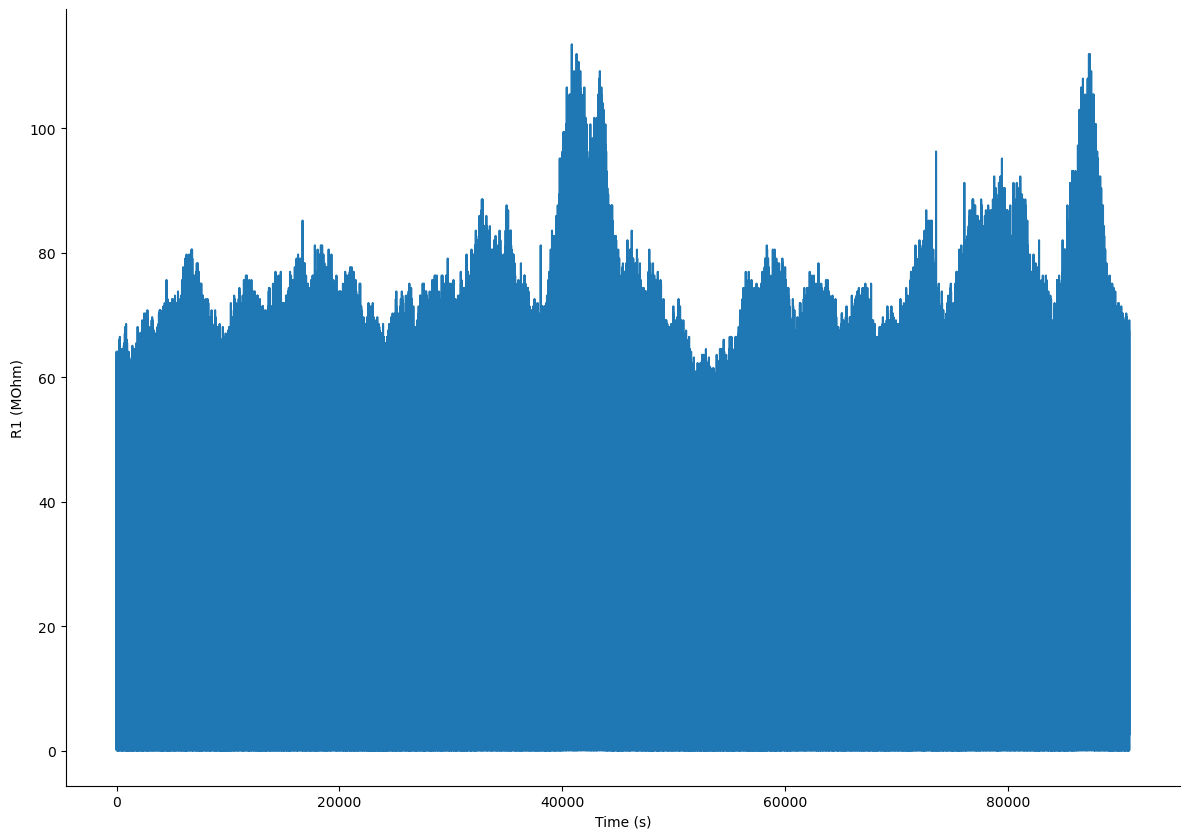

In [30]:
sns.relplot(data=day_1, x='Time (s)', y='CO (ppm)', kind='line', height=8.5, aspect=12/8.5)
sns.relplot(data=day_1, x='Time (s)', y='R1 (MOhm)', kind='line', height=8.5, aspect=12/8.5)

In [31]:
CO = list(day_1['CO (ppm)'].value_counts().head(10).index)
day_1_clean = day_1.loc[day_1['CO (ppm)'].isin(CO)]
print(day_1.shape, day_1_clean.shape)

(295719, 20) (295418, 20)


In [32]:
CO

[0.0, 20.0, 6.67, 2.22, 15.56, 8.89, 13.33, 17.78, 11.11, 4.44]

In [33]:
day_1_clean.loc[:, 'Target'] = day_1_clean['CO (ppm)'].map(lambda el : CO.index(el))


/tmp/ipykernel_32/2780915251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_1_clean.loc[:, 'Target'] = day_1_clean['CO (ppm)'].map(lambda el : CO.index(el))


In [ ]:
#sns.relplot(x=day_1_clean.loc[ind[0]:ind[0]+2908 ,'Time (s)'], y=day_1_clean['R1 (MOhm)'], kind='line') #0ppm
#sns.relplot(x=day_1_clean.loc[ind[0]:ind[0]+2908 ,'Time (s)'], y=day_1_clean['R1 (MOhm)'], kind='line') #20ppm

In [13]:
'''day_1_clean.reset_index(inplace=True, drop=True)
day_1_clean
columns_to_drop = ['Time (s)',
                   'CO (ppm)',
                   'Humidity (%r.h.)',
                   'Temperature (C)',
                   'Flow rate (mL/min)']

day_1_clean.drop(columns=columns_to_drop, inplace=True)
day_1_clean.columns = ['HeaterVolt'] + [f'R{i}' for i in range(1,15)] + ['Target']
day_1_clean
'''

"day_1_clean.reset_index(inplace=True, drop=True)\nday_1_clean\ncolumns_to_drop = ['Time (s)',\n                   'CO (ppm)',\n                   'Humidity (%r.h.)',\n                   'Temperature (C)',\n                   'Flow rate (mL/min)']\n\nday_1_clean.drop(columns=columns_to_drop, inplace=True)\nday_1_clean.columns = ['HeaterVolt'] + [f'R{i}' for i in range(1,15)] + ['Target']\nday_1_clean\n"

In [19]:
day_1_clean.reset_index(inplace=True, drop=True)
ind = [0]
for i in range(day_1_clean.shape[0]-1):
    if day_1_clean['CO (ppm)'][i] != day_1_clean['CO (ppm)'][i+1]:
        ind.append(i)
        ind.append(i+1)


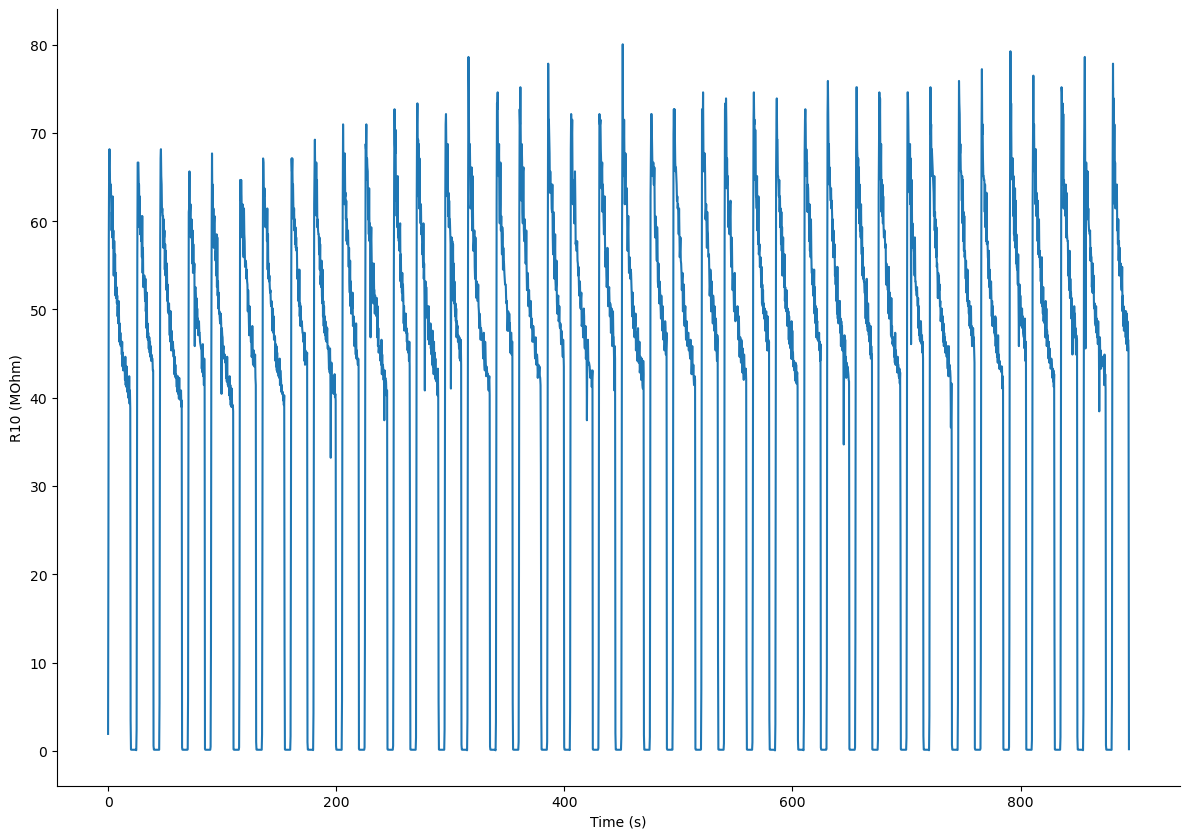

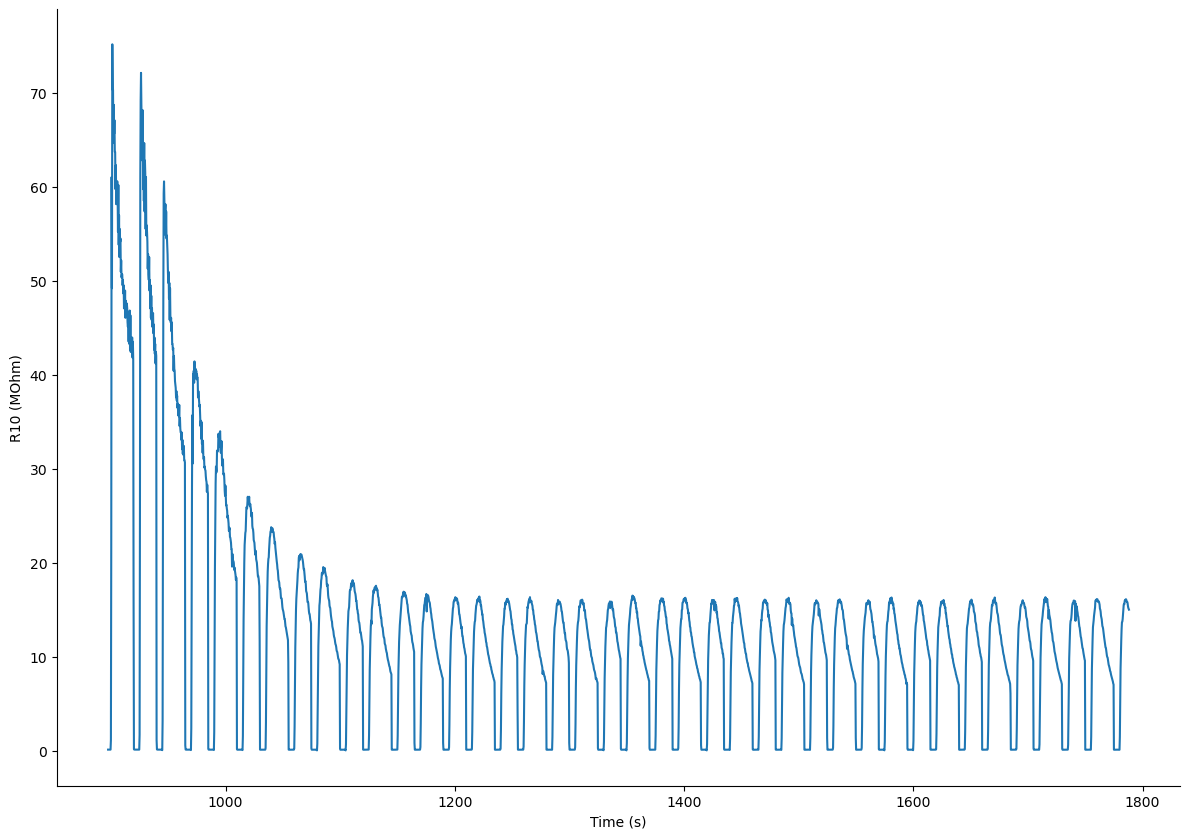

In [39]:
sns.relplot(x=day_1_clean.loc[ind[0]:ind[0]+2908 ,'Time (s)'], y=day_1_clean['R10 (MOhm)'], kind='line', height=8.5, aspect=12/8.5) #0ppm
sns.relplot(x=day_1_clean.loc[ind[2]:ind[2]+2908 ,'Time (s)'], y=day_1_clean['R10 (MOhm)'], kind='line', height=8.5, aspect=12/8.5) #20ppm

In [40]:
min_sample = min([ind[i] - ind[i-1] for i in range(1, len(ind), 2)])
min_sample

2908

In [41]:
day_1_clean.reset_index(inplace=True, drop=True)
day_1_clean
columns_to_drop = ['Time (s)',
                   'CO (ppm)',
                   'Humidity (%r.h.)',
                   'Temperature (C)',
                   'Flow rate (mL/min)']

day_1_clean.drop(columns=columns_to_drop, inplace=True)
day_1_clean.columns = ['HeaterVolt'] + [f'R{i}' for i in range(1,15)] + ['Target']

samples = []
targets = []
for i in range(0, len(ind)-2, 2):
    samples.append(day_1_clean.iloc[ind[i]:ind[i]+min_sample, :-1].values)
    targets.append(day_1_clean.at[ind[i], 'Target'])
samples = np.array(samples)

/tmp/ipykernel_32/1836351454.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_1_clean.drop(columns=columns_to_drop, inplace=True)


In [42]:
y = to_categorical(targets, 10)

X_train, X_test, y_train, y_test = train_test_split(np.array(samples), y, shuffle=True, random_state=42)



In [50]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(20, input_shape=(2908, 15), dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=5, epochs=60, validation_split=0.2)

Epoch 1/60
11/11 [==============================] - 25s 2s/step - loss: 2.3021 - accuracy: 0.0556 - val_loss: 2.3163 - val_accuracy: 0.0714
Epoch 2/60
11/11 [==============================] - 22s 2s/step - loss: 2.2832 - accuracy: 0.1296 - val_loss: 2.3199 - val_accuracy: 0.0714
Epoch 3/60
11/11 [==============================] - 22s 2s/step - loss: 2.2485 - accuracy: 0.2222 - val_loss: 2.3033 - val_accuracy: 0.0714
Epoch 4/60
11/11 [==============================] - 22s 2s/step - loss: 2.2243 - accuracy: 0.2593 - val_loss: 2.2985 - val_accuracy: 0.1429
Epoch 5/60
11/11 [==============================] - 22s 2s/step - loss: 2.1989 - accuracy: 0.2593 - val_loss: 2.2911 - val_accuracy: 0.1429
Epoch 6/60
11/11 [==============================] - 22s 2s/step - loss: 2.1382 - accuracy: 0.3333 - val_loss: 2.2774 - val_accuracy: 0.2143
Epoch 7/60
11/11 [==============================] - 21s 2s/step - loss: 2.1163 - accuracy: 0.2778 - val_loss: 2.2633 - val_accuracy: 0.2143
Epoch 8/60
11/11 [==